# Deep Learning with PyTorch Workshop

* [Video](https://www.youtube.com/watch?v=Ne25VujHRLA)
* [Original Colab Notebook](https://colab.research.google.com/drive/1nCA4Q0f8DVFiLpfXdXvZtYUh-yYDy5i_?usp=sharing)

This workshop introduces deep learning for image classification using PyTorch. It is based on the ML Zoomcamp Deep Learning module but adapted to use PyTorch instead of TensorFlow/Keras.

## Workshop Overview

In this workshop, you will learn how to build an image classification model using PyTorch and transfer learning. We'll work with a clothing dataset and progressively improve our model through experimentation and optimization.

## Plan

- Introduction to PyTorch for deep learning
- Loading and preprocessing image data
- Using pre-trained models (MobileNetV2)
- Understanding convolutional neural networks (CNNs)
- Transfer learning: adapting pre-trained models
- Hyperparameter tuning: learning rate optimization
- Model checkpointing: saving the best model
- Adding more layers to improve performance
- Dropout regularization to prevent overfitting
- Data augmentation for better generalization
- Training the final model
- Using the model for predictions
- Exporting models to ONNX format


## Prerequisites

Tools:
- PyTorch
- torchvision
- PIL (Pillow)
- NumPy


In [ ]:
# Install required packages (if needed)
# !pip install torch torchvision pillow numpy


## Setup

Download the dataset:


In [1]:
# Download the dataset
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git


Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 42.81 MiB/s, done.
Resolving deltas: 100% (10/10), done.


The dataset contains:
- 10 clothing categories (dress, hat, longsleeve, outwear, pants, shirt, shoes, shorts, skirt, t-shirt)
- Training, validation, and test splits
- Pre-organized directory structure


## 1. Introduction to PyTorch

PyTorch is a popular open-source deep learning framework developed by Facebook's AI Research lab. It provides:
- Dynamic computation graphs (define-by-run)
- Pythonic API
- Strong GPU acceleration
- Rich ecosystem of tools and libraries

### Key Differences from TensorFlow/Keras:

| TensorFlow/Keras | PyTorch |
|------------------|---------|
| `model.fit()` | Manual training loop |
| `ImageDataGenerator` | `Dataset` + `DataLoader` + `transforms` |
| `keras.layers.Dense()` | `nn.Linear()` |
| `keras.Model` | `nn.Module` |
| `.h5` or `.keras` files | `.pth` or `.pt` files |


## 2. PyTorch and Image Loading

### Loading and Preprocessing Images

Images are represented as 3D arrays:
- Height × Width × Channels
- Channels: RGB (Red, Green, Blue)
- Each channel: 8 bits (0-255 values)


In [21]:
from PIL import Image
import numpy as np

# Load an image
image_path = 'clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg'
image = Image.open(image_path)

In [22]:
# Resize to target size
TARGET_IMAGE_SIZE = 224
image = image.resize((TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

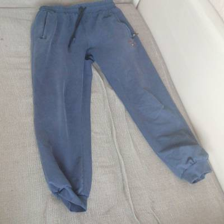

In [23]:
image

In [24]:
# Convert to numpy array
image_array = np.array(image)
print(f'Image shape: {image_array.shape}')  # (224, 224, 3)

Image shape: (224, 224, 3)


## 3. Pre-trained Models

Instead of training from scratch, we'll use a model pre-trained on ImageNet (1.4M images, 1000 classes).

**Why use pre-trained models?**
- Already learned to recognize edges, textures, shapes
- Saves training time
- Works well even with small datasets
- Better performance than training from scratch


### Using MobileNetV2

```text
================================================================================
                        DATA TRANSFORMATION PIPELINE
================================================================================

1. INPUT STATE             2. SPATIAL TRANSFORMS         3. TENSOR TRANSFORMS
(Raw Image)                (Resize & Crop)               (Format & Math)

+-----------------+        +---------------------+       +---------------------+
|                 |        |  transforms.Resize  |       | transforms.ToTensor |
|   Raw Image     |        |       (256)         |       |                     |
|  (Any Size)     |  --->  | Scales shorter side |  ---> | [0, 255] -> [0, 1]  |
|  (e.g. 800x600) |        | to 256px, maintain  |       | (H,W,C) -> (C,H,W)  |
|                 |        | aspect ratio.       |       |                     |
+-----------------+        +----------+----------+       +----------+----------+
                                      |                             |
                                      v                             v
                           +----------+----------+       +----------+----------+
                           |transforms.CenterCrop|       | transforms.Normalize|
                           |       (224)         |       |                     |
                           |   +-------------+   |       |  (val - mean) / std |
                           |   |   224x224   |   |       |                     |
                           |   |   TARGET    |   |       |    Result:          |
                           |   |    AREA     |   |       | Normalized Float32  |
                           |   +-------------+   |       |       Tensor        |
                           +---------------------+       +----------+----------+
                                                                    |
                                                                    v
================================================================================
                                MODEL INFERENCE
================================================================================
                                                                    |
    +---------------------------------------------------------------+
    |
    v
+------------------------------------------------------------------------------+
|                            model = mobilenet_v2                              |
|                         (weights='IMAGENET1K_V1')                            |
|                                                                              |
|  +---------------------+      +---------------------+      +--------------+  |
|  | Input Layer (3 ch)  | ---> | Inverted Residuals  | ---> | Classifier   |  |
|  |    (1, 3, 224, 224) |      | (Bottleneck Blocks) |      | (Linear)     |  |
|  +---------------------+      +---------------------+      +--------------+  |
|                                                                    |         |
+--------------------------------------------------------------------+---------+
                                                                     |
                                                                     v
                                                            +------------------+
                                                            |   OUTPUT LOGITS  |
                                                            |   (1000 Classes) |
                                                            +------------------+
```

In [25]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = 256
CROP_SIZE = 224

# Load pre-trained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(RESIZE_SIZE),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("Model loaded successfully!")


Model loaded successfully!


In [26]:
image = Image.open(
    'clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')

In [27]:
preprocessed_image = preprocess(image)

In [28]:
BATCH_DIMENSION = 0
batch_tensor = torch.unsqueeze(preprocessed_image, BATCH_DIMENSION)

In [29]:
# Make prediction without gradient calculation
with torch.no_grad():
    model_output = model(batch_tensor)

In [30]:
# Get top predictions
DESCENDING_ORDER = True
_, sorted_indices = torch.sort(model_output, descending=DESCENDING_ORDER)
print(f"Top prediction index: {sorted_indices[0, 0].item()}")

Top prediction index: 608


In [16]:
# Download ImageNet class names
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2025-11-30 11:40:05--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-11-30 11:40:05 (96.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [31]:
# Get top 5 predictions
TOP_K_PREDICTIONS = 5
top_k_indices = sorted_indices[0, :TOP_K_PREDICTIONS].tolist()
top_k_classes = [categories[idx] for idx in top_k_indices]

print("Top 5 predictions:")
for rank, class_name in enumerate(top_k_classes, start=1):
    print(f"{rank}: {class_name}")


Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


**Key concepts:**
- Input size: MobileNetV2 expects 224×224 images
- Normalization: Images scaled with ImageNet mean and std
- Batch size: Number of images processed together
- Batch dimension: Shape (batch_size, channels, height, width) - e.g., (1, 3, 224, 224)


NOTE: See [Using pre-trained models (week-8)](docs/Using%20pre-trained%20models%20(week-8).md)

## 4. Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are specialized neural networks for processing grid-like data such as images.

**Key Components:**

1. **Convolutional Layer**: Extracts features using filters
   - Applies filters (e.g., 3×3, 5×5) to detect patterns
   - Creates feature maps (one per filter)
   - Detects edges, textures, shapes

2. **ReLU Activation**: Introduces non-linearity
   - `f(x) = max(0, x)`
   - Sets negative values to 0
   - Helps network learn complex patterns

3. **Pooling Layer**: Down-samples feature maps
   - Reduces spatial dimensions
   - Max pooling: takes maximum value in a region
   - Makes features more robust to small translations

4. **Fully Connected (Dense) Layer**: Final classification
   - Flattens 2D feature maps to 1D vector
   - Connects to output classes

**CNN Workflow:**
```
Input Image → Conv + ReLU → Pooling → Conv + ReLU → Pooling → Flatten → Dense → Output
```


## 5. Transfer Learning

Transfer Learning reuses a model trained on one task (ImageNet) for a different task (clothing classification).

**Approach:**
1. Load pre-trained model (feature extractor)
2. Remove original classification head
3. Freeze convolutional layers
4. Add custom layers for our task
5. Train only the new layers

### Custom Dataset Class


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class ClothingDataset(Dataset):
    """
    Custom PyTorch Dataset for loading clothing images from directory structure.
    
    Args:
        data_dir (str): Path to root directory containing class subdirectories.
        transform (callable, optional): Transform pipeline to apply to images.
    
    Returns:
        tuple: (transformed_image, label_index) when indexed.
    
    Raises:
        FileNotFoundError: If data_dir does not exist.
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        for class_name in self.classes:
            class_directory = os.path.join(data_dir, class_name)
            for image_filename in os.listdir(class_directory):
                image_path = os.path.join(class_directory, image_filename)
                self.image_paths.append(image_path)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

```text
                      ┌──────────────────────────────────────┐
                      │        ClothingDataset Class         │
                      └──────────────────────────────────────┘

                             data_dir/
                                │
          ┌─────────────────────┼──────────────────────────────┐
          ▼                     ▼                              ▼
   data_dir/dress/      data_dir/pants/               data_dir/shirt/
   (img files...)       (img files...)                (img files...)

────────────────────────────────────────────────────────────────────────────
1. __init__(data_dir, transform)
────────────────────────────────────────────────────────────────────────────

INPUT:
    data_dir : path to root folder of dataset
    transform: optional torchvision transform pipeline

PROCESS:
┌──────────────────────────────────────────────────────────────────────────┐
│ Steps performed during initialization:                                   │
│                                                                          │
│ 1. Read all class folder names:                                          │
│       classes = ["dress", "pants", "shirt", ...]                         │
│                                                                          │
│ 2. Create class → index mapping:                                         │
│       {"dress":0, "pants":1, "shirt":2, ...}                             │
│                                                                          │
│ 3. Walk through each class folder:                                       │
│       For each image found:                                              │
│          - Append full path to image_paths[]                             │
│          - Append class index to labels[]                                │
│                                                                          │
│ Result:                                                                  │
│   image_paths = [ "dir/dress/img1.jpg", "dir/pants/img4.jpg", ... ]      │
│   labels      = [ 0, 1, ... ]                                            │
└──────────────────────────────────────────────────────────────────────────┘

OUTPUT (stored internally):
    self.image_paths : list of full file paths
    self.labels      : list of integer class indices
    self.classes     : list of class names
    self.class_to_idx: dict mapping class → index

────────────────────────────────────────────────────────────────────────────
2. __len__()
────────────────────────────────────────────────────────────────────────────

INPUT:
    None

PROCESS:

                ┌────────────────────────────────────────┐
                │ Returns total number of images         │
                │     len(image_paths)                   │
                └────────────────────────────────────────┘

OUTPUT:
    Integer representing length of dataset

────────────────────────────────────────────────────────────────────────────
3. __getitem__(idx)
────────────────────────────────────────────────────────────────────────────

INPUT:
    idx : integer index into dataset

PROCESS:

                idx ───────────────────────────────┐
                                                   ▼
                                   ┌──────────────────────────────┐
                                   │ image_paths[idx]             │
                                   │  → load image from disk      │
                                   └──────────────────────────────┘
                                                   │
                                                   ▼
                                   ┌──────────────────────────────┐
                                   │ Apply transform (if any)     │
                                   │  e.g., Resize, Crop, ToTensor│
                                   └──────────────────────────────┘
                                                   │
                                                   ▼
                                   ┌──────────────────────────────┐
                                   │ labels[idx] → class index    │
                                   └──────────────────────────────┘
                                                   │
                                                   ▼
                              ┌─────────────────────────────────────────┐
                              │ Returns: (transformed_image, label)     │
                              └─────────────────────────────────────────┘

OUTPUT:
    (image_tensor, label_index)
```

### Simple Preprocessing


In [32]:
from torchvision import transforms

# Image preprocessing constants
INPUT_IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def create_simple_transforms(image_size):
    """
    Creates a simple transform pipeline with resize and normalization.
    
    Args:
        image_size (int): Target size for resizing (height, width).
    
    Returns:
        transforms.Compose: Transform pipeline.
    """
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

# Simple transforms - just resize and normalize
train_transforms = create_simple_transforms(INPUT_IMAGE_SIZE)
val_transforms = create_simple_transforms(INPUT_IMAGE_SIZE)


### Create DataLoaders


In [33]:
from torch.utils.data import DataLoader

# Dataset paths
TRAIN_DATA_DIR = './clothing-dataset-small/train'
VAL_DATA_DIR = './clothing-dataset-small/validation'

# DataLoader hyperparameters
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
SHUFFLE_VAL = False

train_dataset = ClothingDataset(
    data_dir=TRAIN_DATA_DIR,
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir=VAL_DATA_DIR,
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_VAL)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


Training samples: 3068
Validation samples: 341
Number of classes: 10
Classes: ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


NOTE: See [SHUFFLE_TRAIN = True and SHUFFLE_VAL = False (week-8)](docs/SHUFFLE_TRAIN%20=%20True%20and%20SHUFFLE_VAL%20=%20False%20(week-8).md)

### Build the Model


In [35]:
import torch.nn as nn
import torchvision.models as models

# MobileNetV2 architecture constants
MOBILENET_V2_FEATURE_DIM = 1280
ADAPTIVE_POOL_OUTPUT_SIZE = (1, 1)
FLATTEN_START_DIM = 1

class ClothingClassifierMobileNet(nn.Module):
    """
    Clothing classifier using MobileNetV2 as feature extractor.
    
    Uses transfer learning: freezes pre-trained MobileNetV2 weights and adds
    custom classification layers for clothing categories.
    
    Args:
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        torch.Tensor: Logits tensor of shape (batch_size, num_classes).
    """
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove original classifier
        self.base_model.classifier = nn.Identity()  # simply returns the input unchanged
        
        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(ADAPTIVE_POOL_OUTPUT_SIZE)
        self.output_layer = nn.Linear(MOBILENET_V2_FEATURE_DIM, num_classes)

    def forward(self, x):
        features = self.base_model.features(x)
        pooled = self.global_avg_pooling(features)
        flattened = torch.flatten(pooled, FLATTEN_START_DIM)
        logits = self.output_layer(flattened)
        return logits

```text
================================================================================
                    ClothingClassifierMobileNet ARCHITECTURE
================================================================================

   [ INPUT IMAGE ]
   Batch of Images
   (Batch_Size, 3, H, W)
           |
           v
+------------------------------------------------------------------------------+
|  1. FEATURE EXTRACTOR (Backbone)                                             |
|     self.base_model.features                                                 |
|                                                                              |
|  +------------------------------------------+                                |
|  |      MobileNetV2 Pre-trained Layers      | <--- LOADED: "IMAGENET1K_V1"   |
|  |     (Conv2d, BatchNorm, ReLU6, etc.)     | <--- STATUS: FROZEN ❄️         |
|  +------------------------------------------+      (requires_grad = False)   |
|                                                                              |
|  FUNCTION: Extracts complex visual patterns (edges, textures, shapes)        |
|  OUTPUT:   Feature Maps Tensor                                               |
|  SHAPE:    (Batch, 1280, 7, 7)  *Assuming 224x224 input                      |
+------------------------------------------------------------------------------+
           |
           v
+------------------------------------------------------------------------------+
|  2. GLOBAL AVERAGE POOLING                                                   |
|     self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))                   |
|                                                                              |
|  +-------+                                                                   |
|  | 7x7   |   Averages each 7x7 feature map into a single value.              |
|  | Grid  |   Reduces spatial dimensions, keeps depth (channels).             |
|  +-------+                                                                   |
|                                                                              |
|  OUTPUT:   Pooled Tensor                                                     |
|  SHAPE:    (Batch, 1280, 1, 1)                                               |
+------------------------------------------------------------------------------+
           |
           v
+------------------------------------------------------------------------------+
|  3. FLATTEN                                                                  |
|     torch.flatten(pooled, start_dim=1)                                       |
|                                                                              |
|  [ 1280 x 1 x 1 ]  ---->  [ Vector of size 1280 ]                            |
|                                                                              |
|  FUNCTION: Prepares 3D tensor for the Linear layer.                          |
|  SHAPE:    (Batch, 1280)                                                     |
+------------------------------------------------------------------------------+
           |
           v
+------------------------------------------------------------------------------+
|  4. CLASSIFIER HEAD (Custom)                                                 |
|     self.output_layer = nn.Linear(1280, num_classes)                         |
|                                                                              |
|  +------------------------------------------+                                |
|  |           Fully Connected Layer          | <--- STATUS: TRAINABLE 🔥      |
|  |          (Weights initialized)           |      (Gradients Active)        |
|  +------------------------------------------+                                |
|                                                                              |
|  FUNCTION: Maps features to specific clothing categories.                    |
|  OUTPUT:   Logits (Raw scores)                                               |
|  SHAPE:    (Batch, 10)                                                       |
+------------------------------------------------------------------------------+
           |
           v
    [ OUTPUT LOGITS ]
```

### Train the Model


In [36]:
import torch
import torch.optim as optim

# Training hyperparameters
NUM_CLASSES = 10
INITIAL_LEARNING_RATE = 0.01

# Select the device to run the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [40]:
# Create the model
model = ClothingClassifierMobileNet(num_classes=NUM_CLASSES)

# Move the model to the device
model.to(device)

ClothingClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [41]:
# Create the optimizer  
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LEARNING_RATE)

# Create the loss function
criterion = nn.CrossEntropyLoss()


In [42]:
# Training loop
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients to prevent accumulation
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        running_loss += loss.item()

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of samples and the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate the average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move the inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate the validation loss
            val_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples and the number of correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate the average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/10
  Train Loss: 1.4303, Train Acc: 0.6183
  Val Loss: 1.1187, Val Acc: 0.6716
Epoch 2/10
  Train Loss: 0.7459, Train Acc: 0.7735
  Val Loss: 0.9835, Val Acc: 0.7625
Epoch 3/10
  Train Loss: 0.6292, Train Acc: 0.8048
  Val Loss: 0.9177, Val Acc: 0.7390
Epoch 4/10
  Train Loss: 0.6728, Train Acc: 0.8041
  Val Loss: 0.9751, Val Acc: 0.7507
Epoch 5/10
  Train Loss: 0.6375, Train Acc: 0.8237
  Val Loss: 0.9843, Val Acc: 0.7478
Epoch 6/10
  Train Loss: 0.5901, Train Acc: 0.8295
  Val Loss: 1.1612, Val Acc: 0.7243
Epoch 7/10
  Train Loss: 0.5154, Train Acc: 0.8527
  Val Loss: 0.9704, Val Acc: 0.7683
Epoch 8/10
  Train Loss: 0.4558, Train Acc: 0.8605
  Val Loss: 1.3740, Val Acc: 0.7449
Epoch 9/10
  Train Loss: 0.4937, Train Acc: 0.8589
  Val Loss: 0.8929, Val Acc: 0.7889
Epoch 10/10
  Train Loss: 0.4264, Train Acc: 0.8755
  Val Loss: 1.2429, Val Acc: 0.7478


**Important Notes:**

- `optimizer.zero_grad()` is crucial - it clears old gradients before calculating new ones. (see [Gradients accumulate (week-8)](docs/Gradients%20accumulate%20(week-8).md))
- `model.train()` sets the model to training mode (activates dropout, batch norm updates)
- `model.eval()` sets the model to evaluation mode (deactivates dropout, uses accumulated batch norm stats)

Let's put the training loop inside a function for easier reuse:


In [43]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    Trains the model for one epoch.
    
    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function.
        device: Device to run training on (cuda/cpu).
    
    Returns:
        tuple: (average_loss, accuracy) for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return average_loss, accuracy

def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluates the model on validation data.
    
    Args:
        model: PyTorch model to evaluate.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        device: Device to run evaluation on (cuda/cpu).
    
    Returns:
        tuple: (average_loss, accuracy) for validation set.
    """
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    average_loss = val_loss / len(val_loader)
    accuracy = val_correct / val_total
    return average_loss, accuracy

def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    """
    Trains and evaluates a model for multiple epochs.
    
    Args:
        model: PyTorch model to train.
        optimizer: Optimizer for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        num_epochs (int): Number of training epochs.
        device: Device to run training on (cuda/cpu).
    """
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


## 6. Tuning the Learning Rate

The learning rate controls how much to update model weights during training. It's one of the most important hyperparameters.

**Analogy: Reading speed**
- Too fast: Skip details, poor understanding (may not converge)
- Too slow: Never finish the book (training takes too long)
- Just right: Good comprehension and efficiency

**Experimentation approach:**
1. Try multiple values: `[0.0001, 0.001, 0.01, 0.1]`
2. Train for a few epochs each
3. Compare validation accuracy
4. Choose the rate with best performance and smallest train/val gap


In [44]:
def make_model(learning_rate=0.01, num_classes=10):
    """
    Creates a new model and optimizer with specified learning rate.
    
    Args:
        learning_rate (float): Learning rate for optimizer. Default is 0.01.
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        tuple: (model, optimizer) ready for training.
    """
    model = ClothingClassifierMobileNet(num_classes=num_classes)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [45]:
# Test different learning rates
LEARNING_RATES_TO_TEST = [0.0001, 0.001, 0.01, 0.1]
NUM_EPOCHS_FOR_TESTING = 3

for learning_rate in LEARNING_RATES_TO_TEST:
    print(f'\n=== Learning Rate: {learning_rate} ===')
    model, optimizer = make_model(learning_rate=learning_rate, num_classes=NUM_CLASSES)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, NUM_EPOCHS_FOR_TESTING, device)



=== Learning Rate: 0.0001 ===
Epoch 1/3
  Train Loss: 2.0019, Train Acc: 0.3152
  Val Loss: 1.7765, Val Acc: 0.3519
Epoch 2/3
  Train Loss: 1.6365, Train Acc: 0.4769
  Val Loss: 1.4951, Val Acc: 0.5660
Epoch 3/3
  Train Loss: 1.4053, Train Acc: 0.5834
  Val Loss: 1.2994, Val Acc: 0.5982

=== Learning Rate: 0.001 ===
Epoch 1/3
  Train Loss: 1.3170, Train Acc: 0.5916
  Val Loss: 0.8394, Val Acc: 0.7302
Epoch 2/3
  Train Loss: 0.7722, Train Acc: 0.7656
  Val Loss: 0.6904, Val Acc: 0.7889
Epoch 3/3
  Train Loss: 0.6243, Train Acc: 0.8028
  Val Loss: 0.6298, Val Acc: 0.7801

=== Learning Rate: 0.01 ===
Epoch 1/3
  Train Loss: 1.3806, Train Acc: 0.6320
  Val Loss: 1.1388, Val Acc: 0.7038
Epoch 2/3
  Train Loss: 0.8498, Train Acc: 0.7549
  Val Loss: 0.8210, Val Acc: 0.7742
Epoch 3/3
  Train Loss: 0.7939, Train Acc: 0.7764
  Val Loss: 0.8624, Val Acc: 0.7713

=== Learning Rate: 0.1 ===
Epoch 1/3
  Train Loss: 15.6258, Train Acc: 0.5655
  Val Loss: 7.0629, Val Acc: 0.6422
Epoch 2/3
  Train Los

The best learning rate is typically 0.001.


## 7. Model Checkpointing

Checkpointing saves the model during training to:
- Keep the best performing model
- Resume training if interrupted
- Avoid losing progress


In [46]:
def save_checkpoint(model, epoch, val_accuracy, checkpoint_prefix='mobilenet_v2'):
    """
    Saves model checkpoint with formatted filename.
    
    Args:
        model: PyTorch model to save.
        epoch (int): Current epoch number.
        val_accuracy (float): Validation accuracy for filename.
        checkpoint_prefix (str): Prefix for checkpoint filename.
    
    Returns:
        str: Path to saved checkpoint file.
    """
    checkpoint_path = f'{checkpoint_prefix}_{epoch+1:02d}_{val_accuracy:.3f}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    return checkpoint_path

def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    """
    Trains and evaluates a model with checkpointing for best validation accuracy.
    
    Args:
        model: PyTorch model to train.
        optimizer: Optimizer for updating model parameters.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        num_epochs (int): Number of training epochs.
        device: Device to run training on (cuda/cpu).
    """
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = save_checkpoint(model, epoch, val_acc)
            print(f'Checkpoint saved: {checkpoint_path}')

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


NOTE: See [Model Checkpointing (week-8)](docs/Model%20Checkpointing%20(week-8).md)

## 8. Adding Inner Layers

We can add intermediate dense layers between feature extraction and output:


In [ ]:
class ClothingClassifierMobileNet(nn.Module):
    """
    Clothing classifier with inner dense layer using MobileNetV2 as feature extractor.
    
    Args:
        size_inner (int): Size of inner dense layer. Default is 100.
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        torch.Tensor: Logits tensor of shape (batch_size, num_classes).
    """
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(ADAPTIVE_POOL_OUTPUT_SIZE)

        # Add the inner layer
        self.inner = nn.Linear(MOBILENET_V2_FEATURE_DIM, size_inner)

        # Add the ReLU activation
        self.relu = nn.ReLU()

        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        features = self.base_model.features(x)
        pooled = self.global_avg_pooling(features)
        flattened = torch.flatten(pooled, FLATTEN_START_DIM)
        inner_output = self.inner(flattened)
        activated = self.relu(inner_output)
        logits = self.output_layer(activated)
        return logits


In [48]:
# Inner layer size options for experimentation
INNER_LAYER_SIZES_TO_TEST = [10, 100, 1000]
DEFAULT_INNER_SIZE = 100
BEST_LEARNING_RATE = 0.001

def make_model(learning_rate=BEST_LEARNING_RATE, size_inner=DEFAULT_INNER_SIZE, num_classes=NUM_CLASSES):
    """
    Creates a new model with inner layer and optimizer.
    
    Args:
        learning_rate (float): Learning rate for optimizer. Default is 0.001.
        size_inner (int): Size of inner dense layer. Default is 100.
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        tuple: (model, optimizer) ready for training.
    """
    model = ClothingClassifierMobileNet(
        num_classes=num_classes,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

# Experiment with different sizes
# Try: size_inner = [10, 100, 1000]
# Larger layers: more capacity, may overfit
# Smaller layers: faster, may underfit


**Key points:**
- Inner layer uses ReLU activation
- Output layer has no activation (logits)
- `CrossEntropyLoss` applies softmax internally

NOTE: See [Adding Inner Layers (week-8)](docs/Adding%20Inner%20Layers%20(week-8).md)


NOTE: See [Adding Inner Layers (week-8)](docs/Adding%20Inner%20Layers%20(week-8).md)

## 9. Dropout Regularization

Dropout randomly drops neurons during training to prevent overfitting.

**How it works:**
- Training: randomly set fraction of activations to 0
- Inference: use all neurons (dropout disabled automatically)
- Creates ensemble effect

**Benefits:**
- Prevents relying on specific features
- Forces learning robust patterns
- Reduces overfitting


In [ ]:
# Dropout hyperparameters
DEFAULT_DROPOUT_RATE = 0.2
DROPOUT_RATES_TO_TEST = [0.0, 0.2, 0.5, 0.8]

class ClothingClassifierMobileNet(nn.Module):
    """
    Clothing classifier with dropout regularization using MobileNetV2 as feature extractor.
    
    Args:
        size_inner (int): Size of inner dense layer. Default is 100.
        droprate (float): Dropout rate (0.0 to 1.0). Default is 0.2.
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        torch.Tensor: Logits tensor of shape (batch_size, num_classes).
    """
    def __init__(self, size_inner=DEFAULT_INNER_SIZE, droprate=DEFAULT_DROPOUT_RATE, num_classes=NUM_CLASSES):
        super(ClothingClassifierMobileNet, self).__init__()
        
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.base_model.classifier = nn.Identity()
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(ADAPTIVE_POOL_OUTPUT_SIZE)
        self.inner = nn.Linear(MOBILENET_V2_FEATURE_DIM, size_inner)
        self.relu = nn.ReLU()

        # Add the dropout
        self.dropout = nn.Dropout(droprate)
        
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        features = self.base_model.features(x)
        pooled = self.global_avg_pooling(features)
        flattened = torch.flatten(pooled, FLATTEN_START_DIM)
        inner_output = self.inner(flattened)
        activated = self.relu(inner_output)
        dropped = self.dropout(activated)
        logits = self.output_layer(dropped)
        return logits


In [50]:
def make_model(
        learning_rate=BEST_LEARNING_RATE,
        size_inner=DEFAULT_INNER_SIZE,
        droprate=DEFAULT_DROPOUT_RATE,
        num_classes=NUM_CLASSES
):
    """
    Creates a new model with inner layer, dropout, and optimizer.
    
    Args:
        learning_rate (float): Learning rate for optimizer. Default is 0.001.
        size_inner (int): Size of inner dense layer. Default is 100.
        droprate (float): Dropout rate. Default is 0.2.
        num_classes (int): Number of output classes. Default is 10.
    
    Returns:
        tuple: (model, optimizer) ready for training.
    """
    model = ClothingClassifierMobileNet(
        num_classes=num_classes,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

# Experimentation:
# Try: droprate = [0.0, 0.2, 0.5, 0.8]
# Typical values: 0.2 to 0.5
# Higher dropout may need more training epochs
# (Best droprate is typically 0.2)


NOTE: See [Regularization and Dropout (week-8)](docs/Regularization%20and%20Dropout%20(week-8).md)

## 10. Data Augmentation

Data Augmentation artificially increases dataset size by applying random transformations to training images.

**Common transformations:**
- Rotation
- Horizontal/vertical flipping
- Zooming (random cropping)
- Shifting
- Shearing

**Important rules:**
- ✅ Apply ONLY to training data
- ❌ Never augment validation/test data


In [51]:
# Data augmentation hyperparameters
MAX_ROTATION_DEGREES = 10
RANDOM_CROP_SCALE_MIN = 0.9
RANDOM_CROP_SCALE_MAX = 1.0

def create_augmented_train_transforms(image_size):
    """
    Creates training transforms with data augmentation.
    
    Args:
        image_size (int): Target size for resizing/cropping.
    
    Returns:
        transforms.Compose: Transform pipeline with augmentation.
    """
    return transforms.Compose([
        transforms.RandomRotation(MAX_ROTATION_DEGREES),
        transforms.RandomResizedCrop(image_size, scale=(RANDOM_CROP_SCALE_MIN, RANDOM_CROP_SCALE_MAX)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

# Training transforms WITH augmentation
train_transforms = create_augmented_train_transforms(INPUT_IMAGE_SIZE)

# Validation transforms - NO augmentation
val_transforms = create_simple_transforms(INPUT_IMAGE_SIZE)

# Recreate datasets with new transforms
train_dataset = ClothingDataset(
    data_dir=TRAIN_DATA_DIR,
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir=VAL_DATA_DIR,
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_VAL)



```text
================================================================================
                       1. TRAINING PIPELINE (Augmented)
             "Make the model learn to recognize the shirt in any condition"
================================================================================

   [ RAW IMAGE ]
   (e.g., T-Shirt)
        |
        v
+-----------------------+      +------------------------------------------------+
| TRANSFORM PIPELINE    | ---> |  create_augmented_train_transforms             |
+-----------------------+      +------------------------------------------------+
        |
        |  1. RandomRotation
        |     (Probability of tilting)
        v
   [ / ] or [ | ] or [ \ ]     <-- Image rotates slightly (-Degrees to +Degrees)
        |
        |  2. RandomResizedCrop
        |     (Zoom in & aspect ratio change)
        v
   [+--+]                      <-- Selects a random patch, then resizes it back
   [|  |]   (Zoomed In)            to target size. Changes scale and ratio.
   [+--+]
        |
        |  3. RandomHorizontalFlip
        |     (50% chance to mirror)
        v
   [  P ]  OR  [  q ]          <-- Helps model learn left/right invariance.
        |
        |  4. ToTensor + Normalize
        v
   [ NORMALIZED TENSOR ]       <-- Ready for the Neural Network


================================================================================
                       2. VALIDATION PIPELINE (Static)
              "Test the model on a standard, clean version of the image"
================================================================================

   [ RAW IMAGE ]
        |
        v
+-----------------------+      +------------------------------------------------+
| TRANSFORM PIPELINE    | ---> |  create_simple_transforms (Implied)            |
+-----------------------+      +------------------------------------------------+
        |
        |  1. Resize + CenterCrop
        |     (Deterministic / Fixed)
        v
   [+--+]                      <-- Always grabs the exact center.
   [|  |]                          No rotation. No flipping.
   [+--+]                          No zooming.
        |
        |  2. ToTensor + Normalize
        v
   [ NORMALIZED TENSOR ]


================================================================================
                       3. DATALOADER & BATCHING
================================================================================

      TRAIN DATASET                         VALIDATION DATASET
      (Size: 10,000)                           (Size: 2,000)
            |                                        |
            v                                        v
+-------------------------+             +-------------------------+
| train_loader            |             | val_loader              |
| (shuffle=SHUFFLE_TRAIN) |             | (shuffle=SHUFFLE_VAL)   |
+-----------+-------------+             +------------+------------+
            |                                        |
    (Mixes indices)                          (Sequential)
    [5, 92, 1, 88...]                        [1, 2, 3, 4...]
            |                                        |
            v                                        v
     [ BATCH OF 32 ]                          [ BATCH OF 32 ]
  (32 distinct, randomized                 (32 standard images)
   variations of images)
```

**1. `RandomResizedCrop` vs. `Resize`**

* **Validation (`Resize`):** Squishes the image to a size or crops the center. It looks exactly like the original photo.
* **Training (`RandomResizedCrop`):** This is aggressive. It might zoom in on just a button, or the sleeve, and stretch it to fill the square.
* **Why?** This forces the model to learn what "fabric" looks like, not just the overall shape of a shirt. It prevents the model from memorizing specific backgrounds.

**2. The Randomness Factor**

* Every time you iterate through `train_loader`, the transforms generate **new** variations.
* If you train for 10 epochs, the model never sees the exact same tensor twice. It sees 10 slightly different versions of the same image (rotated, flipped, zoomed).
**3. Normalization Consistency**

* Notice both pipelines use `transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)`.
* You **never** augment the normalization statistics. You must normalize the validation data using the exact same math as the training data, or the model will see "color casts" it doesn't understand.

**4. `shuffle=True` (Training)**

* Essential for training. Breaking the order of images prevents the model from learning patterns based on the sequence (e.g., "The first 50 images are always shoes").


NOTE: See [Data Augmentation (week-8)](docs/Data%20Augmentation%20(week-8).md)

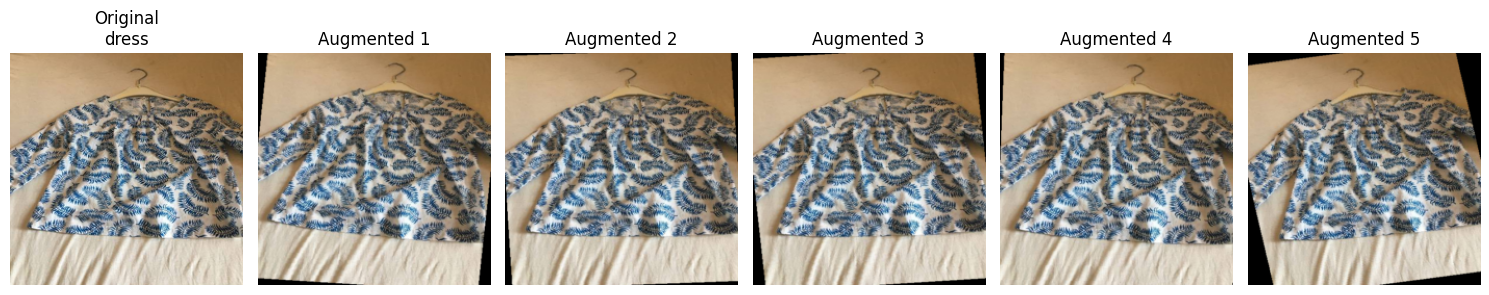

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def denormalize_tensor(tensor):
    """Convert normalized tensor back to image array for display."""
    tensor_copy = tensor.clone()
    for i, (m, s) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        tensor_copy[i] = tensor_copy[i] * s + m
    tensor_copy = torch.clamp(tensor_copy, 0, 1)
    return tensor_copy.permute(1, 2, 0).cpu().numpy()

# Get a sample image
sample_idx = 0
image_path = train_dataset.image_paths[sample_idx]
label = train_dataset.labels[sample_idx]
class_name = train_dataset.classes[label]

# Load original image
original = Image.open(image_path).convert('RGB')
original = original.resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE))
original_array = np.array(original) / 255.0

# Get augmented versions
fig, axes = plt.subplots(1, 6, figsize=(15, 3))

# Show original
axes[0].imshow(original_array)
axes[0].set_title(f'Original\n{class_name}')
axes[0].axis('off')

# Show 5 augmented versions
for i in range(1, 6):
    aug_tensor, _ = train_dataset[sample_idx]
    aug_array = denormalize_tensor(aug_tensor)
    axes[i].imshow(aug_array)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**When to use augmentation:**
1. Small datasets
2. Risk of overfitting
3. Images can appear in different orientations

**Tips:**
- Choose augmentations that make sense for your data
- Too much augmentation can hurt performance
- Usually requires longer training (more epochs)
- If no improvement after ~20 epochs, don't use it


In [53]:
# Train the model with augmented data
NUM_EPOCHS = 50

model, optimizer = make_model(
    learning_rate=BEST_LEARNING_RATE,
    size_inner=DEFAULT_INNER_SIZE,
    droprate=DEFAULT_DROPOUT_RATE
)

criterion = nn.CrossEntropyLoss()

train_and_evaluate_with_checkpointing(
    model, optimizer, train_loader, val_loader, 
    criterion, NUM_EPOCHS, device
)


Checkpoint saved: mobilenet_v2_01_0.751.pth
Epoch 1/50
  Train Loss: 1.4138, Train Acc: 0.5486
  Val Loss: 0.9016, Val Acc: 0.7507
Checkpoint saved: mobilenet_v2_02_0.798.pth
Epoch 2/50
  Train Loss: 0.8619, Train Acc: 0.7213
  Val Loss: 0.6718, Val Acc: 0.7977
Epoch 3/50
  Train Loss: 0.7392, Train Acc: 0.7493
  Val Loss: 0.6266, Val Acc: 0.7713
Epoch 4/50
  Train Loss: 0.6844, Train Acc: 0.7669
  Val Loss: 0.6305, Val Acc: 0.7771
Epoch 5/50
  Train Loss: 0.6237, Train Acc: 0.7901
  Val Loss: 0.5641, Val Acc: 0.7947
Checkpoint saved: mobilenet_v2_06_0.801.pth
Epoch 6/50
  Train Loss: 0.5947, Train Acc: 0.7924
  Val Loss: 0.5497, Val Acc: 0.8006
Epoch 7/50
  Train Loss: 0.5714, Train Acc: 0.8008
  Val Loss: 0.5555, Val Acc: 0.7947
Epoch 8/50
  Train Loss: 0.5469, Train Acc: 0.8178
  Val Loss: 0.6404, Val Acc: 0.7830
Checkpoint saved: mobilenet_v2_09_0.824.pth
Epoch 9/50
  Train Loss: 0.5240, Train Acc: 0.8243
  Val Loss: 0.5629, Val Acc: 0.8240
Epoch 10/50
  Train Loss: 0.4842, Train A

## 11. Using the Trained Model

### Loading a Saved Model


In [54]:
import glob

CHECKPOINT_PATTERN = 'mobilenet_v2_*.pth'

def load_best_checkpoint(model_class, checkpoint_pattern=CHECKPOINT_PATTERN, 
                         size_inner=DEFAULT_INNER_SIZE, droprate=DEFAULT_DROPOUT_RATE, 
                         num_classes=NUM_CLASSES):
    """
    Loads the most recently created checkpoint file.
    
    Args:
        model_class: Model class to instantiate.
        checkpoint_pattern (str): Glob pattern for checkpoint files.
        size_inner (int): Size of inner dense layer.
        droprate (float): Dropout rate.
        num_classes (int): Number of output classes.
    
    Returns:
        tuple: (model, checkpoint_path) if found, (None, None) otherwise.
    """
    checkpoint_files = glob.glob(checkpoint_pattern)
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
        print(f"Loading model from: {latest_checkpoint}")
        
        model = model_class(size_inner=size_inner, droprate=droprate, num_classes=num_classes)
        model.load_state_dict(torch.load(latest_checkpoint))
        model.to(device)
        model.eval()
        return model, latest_checkpoint
    else:
        print("No checkpoint files found. Train a model first.")
        return None, None

# Find best checkpoint
model, checkpoint_path = load_best_checkpoint(ClothingClassifierMobileNet)


Loading model from: mobilenet_v2_09_0.824.pth


### Making Predictions


In [56]:
!pip install keras-image-helper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 121.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_ve

In [57]:
# Install keras-image-helper if needed
# !pip install keras-image-helper

from keras_image_helper import create_preprocessor
import numpy as np

# Image preprocessing constants
PIXEL_VALUE_MAX = 255.0
BATCH_DIM = 0
CHANNEL_DIM = 3
HEIGHT_DIM = 1
WIDTH_DIM = 2
NHWC_TO_NCHW_TRANSPOSE = (0, 3, 1, 2)

CLOTHING_CLASSES = [
    "dress", "hat", "longsleeve", "outwear", "pants",
    "shirt", "shoes", "shorts", "skirt", "t-shirt"
]

def preprocess_pytorch_style(X):
    """
    Preprocesses image array for PyTorch model inference.
    
    Args:
        X: Image array of shape (1, 224, 224, 3), dtype=float32, values in [0, 255].
    
    Returns:
        np.ndarray: Preprocessed array of shape (1, 3, 224, 224), normalized.
    """
    normalized = X / PIXEL_VALUE_MAX
    
    mean_array = np.array(IMAGENET_MEAN).reshape(1, 3, 1, 1)
    std_array = np.array(IMAGENET_STD).reshape(1, 3, 1, 1)
    
    # Convert NHWC → NCHW (batch, height, width, channels → batch, channels, height, width)
    transposed = normalized.transpose(NHWC_TO_NCHW_TRANSPOSE)
    
    # Normalize
    normalized_output = (transposed - mean_array) / std_array
    
    return normalized_output.astype(np.float32)

preprocessor = create_preprocessor(preprocess_pytorch_style, target_size=(INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE))

# Predict from URL
PREDICTION_URL = 'http://bit.ly/mlbookcamp-pants'
preprocessed_input = preprocessor.from_url(PREDICTION_URL)
input_tensor = torch.Tensor(preprocessed_input).to(device)

with torch.no_grad():
    predictions = model(input_tensor).cpu().numpy()[0]

result = dict(zip(CLOTHING_CLASSES, predictions.tolist()))
print(result)


{'dress': 0.9985323548316956, 'hat': -4.506945610046387, 'longsleeve': -0.6967612504959106, 'outwear': 1.1695417165756226, 'pants': 5.794708251953125, 'shirt': -1.0015603303909302, 'shoes': -3.6328442096710205, 'shorts': 0.4260888993740082, 'skirt': -1.5766878128051758, 't-shirt': -3.2896742820739746}


## 12. Exporting to ONNX

ONNX (Open Neural Network Exchange) is a format for model interoperability.

**Benefits:**
- Deploy on different platforms
- Use optimized runtimes (ONNX Runtime)
- Better inference performance
- Language-agnostic deployment


In [ ]:
# -----------------------------------------
# ONNX EXPORT CONSTANTS
# -----------------------------------------

# The dummy batch size for our sample input.
# ONNX export requires one forward pass with a valid input shape.
DUMMY_BATCH_SIZE = 1

# The number of channels in the input image.
NUM_CHANNELS = 3

# Custom names for the ONNX model's input and output nodes.
# These names will appear inside the ONNX graph and are useful during inference.
ONNX_INPUT_NAME = 'input'
ONNX_OUTPUT_NAME = 'output'

# Axis index for the batch dimension (always 0 in NCHW format).
# Used when defining dynamic axes so ONNX can accept variable batch sizes.
BATCH_SIZE_AXIS = 0
ONNX_FILENAME = "clothing_classifier_mobilenet_v2.onnx"

# -----------------------------------------
# CREATE DUMMY INPUT
# -----------------------------------------

# Creates a dummy input tensor to trace the model during ONNX export.
# Shape: (batch_size, channels, height, width)
# INPUT_IMAGE_SIZE must match the size expected by the model (e.g., 224 or 299).
dummy_input = torch.randn(
    DUMMY_BATCH_SIZE,
    NUM_CHANNELS,
    INPUT_IMAGE_SIZE,
    INPUT_IMAGE_SIZE
).to(device)

# -----------------------------------------
# EXPORT MODEL TO ONNX FORMAT
# -----------------------------------------

torch.onnx.export(
    model,
    dummy_input,
    ONNX_FILENAME,
    verbose=True,
    input_names=[ONNX_INPUT_NAME],
    output_names=[ONNX_OUTPUT_NAME],

    # dynamic_axes allows the ONNX model to accept variable batch sizes.
    # Without this, ONNX will fix the batch size to the dummy input (1).
    dynamic_axes={
        ONNX_INPUT_NAME: {BATCH_SIZE_AXIS: 'batch_size'},
        ONNX_OUTPUT_NAME: {BATCH_SIZE_AXIS: 'batch_size'}
    }
)

print(f"Model exported to {ONNX_FILENAME}")

NOTE: See [Exporting to ONNX (week-8)](docs/Exporting%20to%20ONNX%20(week-8).md)

## Summary

### TensorFlow/Keras vs PyTorch Quick Reference

| Concept | TensorFlow/Keras | PyTorch |
|---------|------------------|---------|
| Framework | High-level API (Keras) on TensorFlow | Low-level, explicit control |
| Data Loading | `ImageDataGenerator` | `Dataset` + `DataLoader` |
| Transforms | `preprocessing_function` | `transforms.Compose()` |
| Model | Functional API or Sequential | `nn.Module` class |
| Layers | `keras.layers.Dense()` | `nn.Linear()` |
| Training | `model.fit()` | Manual training loop |
| Loss | `CategoricalCrossentropy` | `CrossEntropyLoss` |
| Optimizer | `keras.optimizers.Adam` | `optim.Adam` |
| Saving | `.h5` or `.keras` | `.pth` or `.pt` |
| Checkpointing | `ModelCheckpoint` callback | Manual in training loop |
| Device | Automatic | Explicit `.to(device)` |

### Key Concepts Learned

1. Transfer Learning: Reuse pre-trained models for new tasks
2. CNN Architecture: Conv layers → Pooling → Dense layers
3. Hyperparameter Tuning: Learning rate is critical
4. Regularization: Dropout prevents overfitting
5. Data Augmentation: Increases effective dataset size
6. Model Checkpointing: Save best models during training
7. PyTorch Workflow: Dataset → DataLoader → Model → Training Loop

### Best Practices

1. Start with pre-trained models (transfer learning)
2. Freeze convolutional layers initially
3. Use appropriate normalization (match pre-training)
4. Experiment with one hyperparameter at a time
5. Monitor train/val gap for overfitting
6. Use checkpointing to save best models
7. Augment training data only, not validation
8. Train longer with dropout and augmentation
9. Use GPU when available: `torch.cuda.is_available()`

### Next Steps

- Try different pre-trained models (ResNet, EfficientNet)
- Experiment with learning rate schedulers
- Fine-tune the entire model (unfreeze convolutional layers)
- Try different optimizers (SGD with momentum, AdamW)
- Deploy the ONNX model
- Explore the original TensorFlow/Keras version


## Resources

- [PyTorch Documentation](https://pytorch.org/docs/)
- [torchvision Models](https://pytorch.org/vision/stable/models.html)
- [ML Zoomcamp Course](https://github.com/DataTalksClub/machine-learning-zoomcamp)
- [ONNX Documentation](https://onnx.ai/)

## Credits

This workshop is based on the ML Zoomcamp Deep Learning module by [Alexey Grigorev](https://github.com/alexeygrigorev), adapted to use PyTorch instead of TensorFlow/Keras.
